<a href="https://colab.research.google.com/github/bachbi/Stat598-FinalProject/blob/main/Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# finanance data
import yfinance as yf

#visualization
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

#date manipulation
from datetime import datetime
import pandas as pd
import numpy as np

#Autoreg and Arima models
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

# statstical testing, plotting and decompositions
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

In [ ]:
start_date = '2020-06-01'
end_date = '2023-12-01'
etf_ticker = 'MLPA'
etf_tickers_url = "https://raw.githubusercontent.com/Aditya-Patel/Stat598-FinalProject/main/mlpa_full-holdings.csv"
crude_oil_stock_url = "https://raw.githubusercontent.com/Aditya-Patel/Stat598-FinalProject/main/crude%20oil%20spot%20price.csv"


In [ ]:
df_holdings = pd.read_csv(etf_tickers_url)
df_holdings = df_holdings[(df_holdings['Name'] != 'OTHER PAYABLE & RECEIVABLES') & (df_holdings['Name'] != 'CASH')]

df_holdings[f'Market Value ($)'] = df_holdings[f'Market Value ($)'].str.replace(',', '').astype(float)
total_market_value = df_holdings[f'Market Value ($)'].sum()
df_holdings['Percentage Holdings By Value'] = (df_holdings[f'Market Value ($)'] / total_market_value)
df_holdings

,% of Net Assets,Ticker,Name,SEDOL,Market Price ($),Shares Held,Market Value ($),Percentage Holdings By Value
0,20.87,ET,ENERGY TRANSFER LP,B0WHXD2,13.33,"22,735,436.84",3.030634e+08,2.004323e-01
1,13.76,EPD,ENTERPRISE PRODU,2285388,26.25,"7,611,951.00",1.998137e+08,1.321477e-01
2,12.17,MPLX,MPLX LP,B847R56,35.87,"4,925,004.00",1.766599e+08,1.168348e-01
3,10.80,PAA,PLAINS ALL AMER,2311960,14.95,"10,486,658.00",1.567755e+08,1.036842e-01
4,10.32,WES,WESTERN MIDSTREA,BJ552C8,28.24,"5,303,028.00",1.497575e+08,9.904279e-02
5,9.47,ENLC,ENLINK MIDSTREAM LLC,BJTNDQ9,12.81,"10,731,120.00",1.374656e+08,9.091352e-02
6,8.26,CQP,CHENIERE ENERGY,B1VNH36,59.30,"2,023,409.00",1.199882e+08,7.935470e-02
7,6.53,NS,NUSTAR ENERGY LP,2738804,19.00,"4,991,913.00",9.484635e+07,6.272705e-02
8,5.91,HESM,HESS MIDSTREAM-A,BKPK695,30.70,"2,795,220.00",8.581325e+07,5.675298e-02
9,4.53,GEL,GENESIS ENERGY L.P.,2372257,12.32,"5,334,251.00",6.571797e+07,4.346287e-02


In [ ]:
df_crude_price = pd.read_csv(crude_oil_stock_url,usecols=[0, 1])

df_crude_price['Date'] = pd.to_datetime(df_crude_price['Date'], format='%b %d, %Y')
df_crude_price.set_index('Date', inplace=True)
df_crude_price.rename(columns={'WTI Barrell Spot Price':'Spot Price'}, inplace=True)

df_crude_price['Spot Price'] = df_crude_price['Spot Price'].fillna(method='ffill')


In [ ]:
all_stocks_data = yf.download(etf_ticker, start=start_date, end=end_date)
#join spot price and etf
all_stocks_data['Ticker'] = etf_ticker
all_stocks_data.columns = [f'{etf_ticker}_{col}' if col not in ['Ticker', 'Date'] else col for col in all_stocks_data.columns]
all_stocks_data = all_stocks_data.join(df_crude_price, how='left')



[*********************100%%**********************]  1 of 1 completed


In [ ]:
# load all tickers part of that etf
for ticker in df_holdings['Ticker']:
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    percentage_holding = df_holdings.loc[df_holdings['Ticker'] == ticker, 'Percentage Holdings By Value'].iloc[0]
    all_stocks_data[f'{ticker}_Percent_Holding'] = percentage_holding
    stock_data.columns = [f'{ticker}_{col}' if col != 'Ticker' else col for col in stock_data.columns]

    all_stocks_data = all_stocks_data.join(stock_data, how='outer')

all_stocks_data.fillna(0, inplace=True)


sum_values = pd.Series(0, index=all_stocks_data.index)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [ ]:
all_stocks_data[f'{etf_ticker}_Next_Close'] = all_stocks_data[f'{etf_ticker}_Close'].shift(-1)
all_stocks_data = all_stocks_data.drop(all_stocks_data.index[-1])
close_values = all_stocks_data[[col for col in all_stocks_data.columns if '_Close' in col or col == 'Spot Price' or col == f'{etf_ticker}_Next_Close']]

print(close_values.columns)


Index(['MLPA_Close', 'Spot Price', 'ET_Close', 'EPD_Close', 'MPLX_Close',
       'PAA_Close', 'WES_Close', 'ENLC_Close', 'CQP_Close', 'NS_Close',
       'HESM_Close', 'GEL_Close', 'DKL_Close', 'PSX_Close', 'MLPX_Close',
       'CAPL_Close', 'SMLP_Close', 'GPP_Close', 'NGL_Close', 'MMLP_Close',
       'SNMP_Close', 'USDP_Close', 'MLPA_Next_Close'],
      dtype='object')


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split


feature_columns = [col for col in all_stocks_data.columns if ('_Close' in col or 'Spot' in col) and etf_ticker not in col]

train, test = train_test_split(close_values, test_size=0.8, random_state=42)


X_train = train[feature_columns]
y_train = train[f'{etf_ticker}_Next_Close']

X_test  = test[feature_columns]
y_test  = test[f'{etf_ticker}_Next_Close']


params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'learning_rate': 0.01,
    'n_estimators': 1000
}


model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train)



def evaluate_model(model, X_valid, y_valid, target_name):
    predictions = model.predict(X_valid)
    mse = mean_squared_error(y_valid, predictions)
    print(f'{target_name} MSE: {mse}')



evaluate_model(model, X_test, y_test, 'Price')
predictions_series = pd.Series(model.predict(X_test), index=y_test.index)



Price MSE: 0.6429580001087908


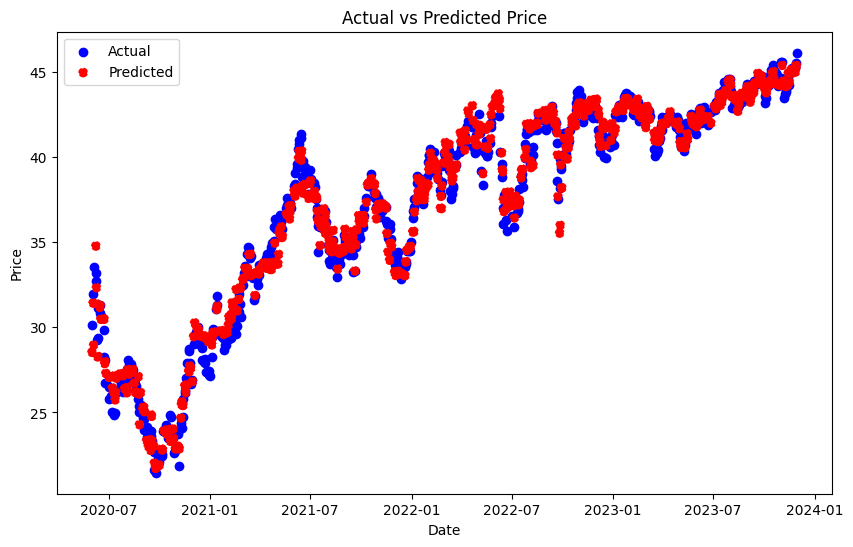

In [ ]:



def plot_actual_vs_predicted(actual, predicted, target_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(actual.index, actual, color='blue', label='Actual')
    plt.scatter(predicted.index, predicted, color='red',  linestyle='dashed',  label='Predicted')  # Changed this line
    plt.title(f'Actual vs Predicted {target_name}')
    plt.xlabel('Date')
    plt.ylabel(target_name)
    plt.legend()
    plt.show()


plot_actual_vs_predicted(y_test, predictions_series, 'Price')

